# 07-03. 신경망 모델 훈련

## 손실 곡선
- 케라스의 fit() 메서드는 손실과 정확도값이 저장된 History 객체를 반환하며 이 값을 사용해 손실 곡선을 그릴 수 있다.

In [1]:
# 데이터 로드 후 세트 분할

from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# 모델을 생성하는 함수 정의

def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:  # a_layer 매개변수를 통해 층을 더 추가할 수 있음
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

In [3]:
# 모델 생성하기

model = model_fn()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# fit() 메서드의 출력값을 변수에 저장

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)  # verbase(default:1)을 0으로 두면 훈련 과정을 출력하지 않으며, 2로 두면 손실 지표만 출력

In [5]:
# history 객체의 history 딕셔너리의 키를 출력
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


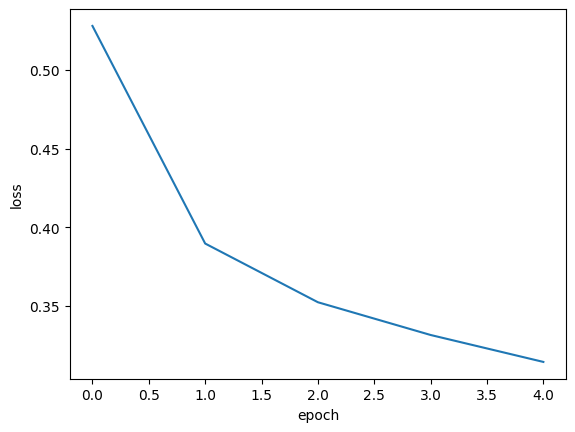

In [6]:
# 손실에 대한 그래프 그리기

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

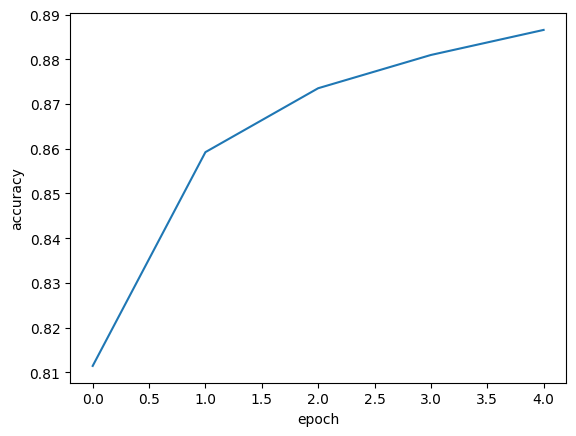

In [7]:
# 정확도에 대한 그래프 그리기

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

- 에포크가 늘수록 손실이 감소하고 정확도가 향상된다.

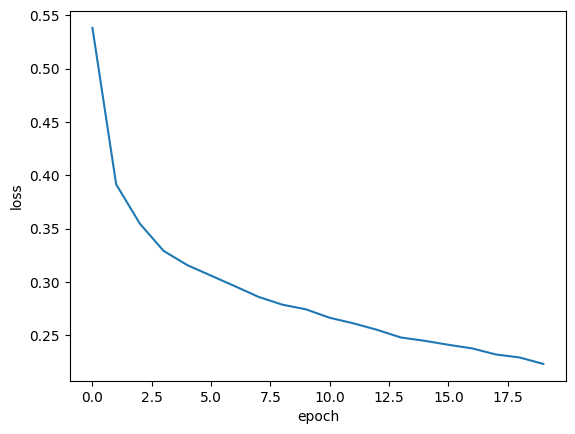

In [8]:
# 에포크 횟수가 20인 모델을 사용해 그래프 그리기

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

- 에포크가 늘어남에 따라 손실은 더욱 감소한다.

## 검증 손실
- 인공 신경망은 경사 하강법을 사용하기 때문에 동일하게 에포크 횟수에 따른 과대/과소적합 문제가 발생할 수 있으며 4장의 로지스틱 회귀와 다르게 손실을 사용해 문제를 진단한다.
  - 에포크가 너무 적으면 과소적합, 너무 많으면 과대적합
- 과대/과소적합 문제를 해결하기 위한 방법
  - 옵티마이저와 하이퍼파라미터를 직접 조정
  - 드롭아웃

- fit() 메서드의 validation_data 파라미터에 (검증 데이터, 검증 타깃)을 튜플 형태로 전달해 각 에포크마다 검증 손실을 계산할 수 있다.

In [10]:
# 에포크마다 검증 손실을 저장하는 모델 생성

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


- 기존의 데이터에 검증 세트에 대한 손실과 정확도가 추가로 포함되어 있다.

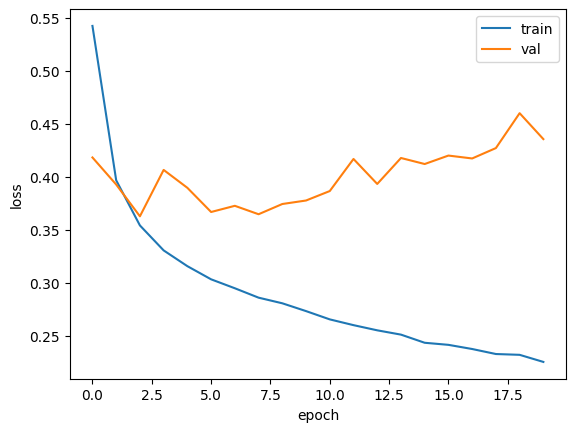

In [11]:
# 훈련 손실과 검증 손실을 사용해 그래프 그리기

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 손실이 불안정하게 움직이며 2 ~ 5번째 에포크 사이에서 처음으로 검증 손실이 상승한다.

### 옵티마이저와 하이퍼파라미터 직접 조정
- 적응적 학습률을 사용하는 Adam 옵티마이저를 사용해 문제를 해결

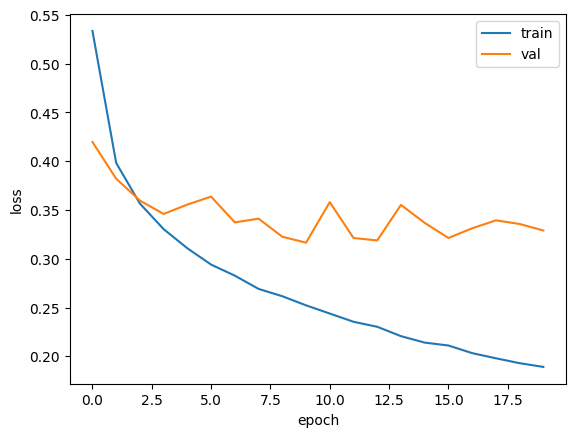

In [13]:
# Adam 옵티마이저를 사용하는 모델을 사용해 그래프 그리기

model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과대적합이 감소하고 이전에 비해 안정된 모습을 보인다.
- 9 ~ 10번째 에포크쯤에서 검증 손실이 다시 상승한다.

### 드롭아웃(dropout)
- 신경망에 특화된 규제 방법으로 훈련 과정 중 층에 있는 일부 랜덤한 뉴런의 출력을 0으로 만들어 과대적합을 막는 방식
- 일부 뉴런이 랜덤하게 드롭되면 특정 뉴런이 과도하게 영향을 주는 것을 방지할 수 있다.
- 케라스의 Dropout 클래스
  - keras.layers 패키지 아래에 포함되어 있으며, 어떠한 층 뒤에 배치해 해당 층의 출력을 랜덤하게 드롭한다.
  - Flatten 클래스와 비슷하게 모델 파라미터는 없지만 하나의 층으로 취급된다.

In [15]:
# 모델에 Dropout 객체를 전달하여 모델 생성

model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

- 케라스는 평가와 예측 시 자동으로 드롭아웃을 적용하지 않는다.

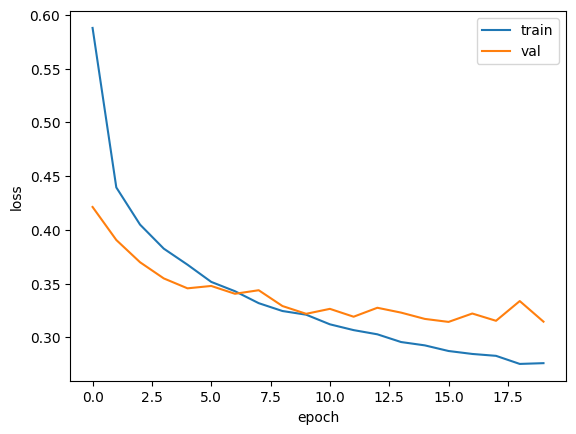

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델의 저장과 복원을 위한 메서드
- save_weights('파일명'): 모델의 파라미터를 저장하는 메서드   
텐서플로의 체크포인트 포맷으로 저장
- save('파일명'): 모델의 구조와 파라미터를 저장하는 메서드   
텐서플로의 SavedModel 포맷으로 저장
- load_weights('파일명'): 저장한 파라미터를 적재하는 메서드   
파라미터를 생성한 모델과 정확히 같은 구조를 가진 모델에서만 사용 가능
- load_model('파일명'): 저장된 모델을 불러오는 메서드
- 파일의 확장자가 .h5일 경우 HDF5 포맷으로 저장

In [18]:
# 모델 생성 후 저장

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

model.save_weights('model.weights.h5')  # 파일명이 '.weights.h5'로 끝나야함
model.save('model-whole.h5')

In [19]:
# 파일이 만들어졌는지 확인
!ls -al *.h5

-rw-r--r-- 1 root root 971928 Nov 30 01:09 model.weights.h5
-rw-r--r-- 1 root root 978584 Nov 30 01:09 model-whole.h5


### 저장한 파라미터 이용하기

In [20]:
# 훈련되지 않은 새로운 모델을 만들고 저장한 파라미터를 적재해 사용

model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- 케라스의 predict()는 샘플마다 각 클래스에 대한 확률을 반환한다.(이진분류라면 양성 클래스에 대한 확률 하나만 반환)
- 여기에서는 검증 세트 샘플 개수가 12000개, 클래스가 10개이므로 (12000, 10) 크기의 배열이 반환된다.

In [21]:
# 모델의 정확도 계산
# 넘파이의 argmax()를 사용하여 각 샘플별 클래스에 대한 확률 중 최대값을 찾고 타깃값과 비교하여 정확도를 계산한다.

import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)  # axis=0: 열 방향 계산, axis=1: 행 방향 계산, axis=-1: 마지막 차원 계산
print(np.mean(val_labels == val_target))  # argmax()는 최대값의 인덱스(클래스의 순서)를 반환하기 때문에 타깃값과 일치한다.

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.88725


### 저장한 모델 이용하기

In [28]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)  # load_model은 모델의 구조 및 옵티마이저 상태까지 복원하기 때문에 evaluate을 사용 가능하다.

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8903 - loss: 0.3324


[0.33853742480278015, 0.8872500061988831]

- 동일한 모델을 사용했기 때문에 같은 정확도를 보인다.

## 콜백(callback)
- 훈련 과정 중간에 어떤 작업을 수행할 수 있도록 하는 객체로 keras.collbacks 패키지 하위에 위치
- 콜백 객체를 생성한 후 fit() 메서드의 callbacks 파라미터에 전달해 사용한다.

### ModelCheckpoint 콜백
- 각 에포크마다 모델을 저장하는 기능
- save_best_only 파라미터를 True로 설정하면 최상의 검증 점수를 보이는 모델을 저장할 수 있다.

In [26]:
# 모델과 콜백 객체를 생성한 후 모델 훈련

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras', save_best_only=True)  # 버전이 달라지면서 이제는 '.h5' 대신 '.keras'만 사용 가능
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [30]:
# 위에서 구한 최적의 모델을 다시 불러온 후 평가

model = keras.models.load_model('best-model.keras')
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8897 - loss: 0.3118


[0.31725654006004333, 0.8883333206176758]

- ModelCheckpoint 콜백을 통해 최적의 모델을 자동으로 저장했으나 여전히 20번의 에포크를 그대로 진행한다.

## EarlyStopping 콜백
- 조기 종료를 수행하는 기능
  - 조기 종료: 검증 손실의 상승이 나타나면 훈련을 중지하는 것으로 컴퓨터의 자원과 시간을 절약하기 위해 사용   
  에포크의 횟수를 제한하는 역할이지만 과대적합을 막아주기 때문에 규제의 일종으로 생각할 수 있다.
- patience 매개변수를 통해 검증 손실이 낮아지지 않더라도 에포크를 진행할 횟수를 설정한다.
  - ex. patience=2라면 2번 연속 검증 손실이 낮아지지 않을 때 훈련을 중단한다.
- restore_best_weights 매개변수를 True로 설정하면 훈련 이후 가장 낮은 검증 손실을 낸 모델 파라미터로 상태를 되돌린다.

In [33]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

print(early_stopping_cb.stopped_epoch)  # 몇 번째 에포크에서 훈련을 중단했는지 확인할 수 있다.

11


- patience=2이므로 최상의 모델은 11-1=10번째 에포크이다.

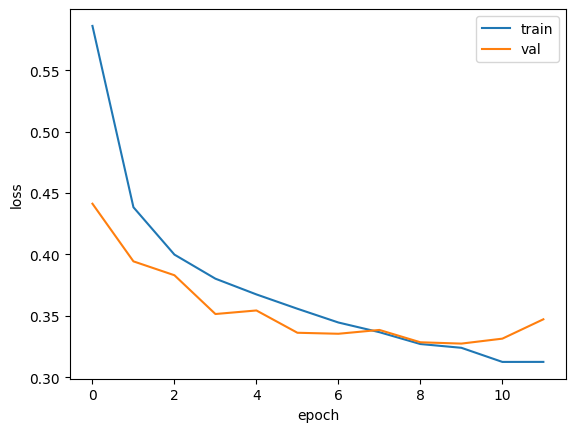

In [34]:
# 그래프로 훈련 손실과 검증 손실 확인

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 10번째 에포크에서 가장 낮은 손실을 확인할 수 있다.

In [36]:
# 검증 세트에 대한 성능 확인
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8816 - loss: 0.3287


[0.3273612856864929, 0.8833333253860474]